In [7]:
!pip install torch_geometric

In [1]:
import networkx as nx
import torch
import os
import pandas as pd
from torch_geometric.data import Data
import numpy as np
from dateutil.parser import parse

In [11]:
np.random.seed(42)

In [12]:
# process data
# each node is a team (for a year), edges
game_info = pd.read_csv("nfl-game-info.csv")
# team_info = pd.read_csv("team_stats_2003_2023.csv")

teams = pd.concat([game_info['Home Team'], game_info['Away Team']]).unique()
teams = list(teams)
teams.remove('San Diego Chargers')
teams.remove('Washington Redskins')
teams.remove('St. Louis Rams')
teams.remove('Oakland Raiders')
teams.remove('Washington Football Team')
teams = np.array(teams)
print(teams)
team_to_idx = {team: i for i, team in enumerate(teams)}

edge_index = []
edge_attr = []

for _, row in game_info.iterrows():
  date = parse(row["Date"])
  if date < parse('2024-9-5'):
    continue
  # create an edge between two teams,
  team1_idx = team_to_idx[row['Home Team']]
  team2_idx = team_to_idx[row['Away Team']]

  # Add an undirected edge (team1 -> team2 and team2 -> team1)
  edge_index.append([team1_idx, team2_idx])
  edge_index.append([team2_idx, team1_idx])

  edge_attr.append([row["Home Score"], row["Away Score"]])
  edge_attr.append([row["Away Score"], row["Home Score"]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))
print(data)

['Pittsburgh Steelers' 'San Francisco 49ers' 'Denver Broncos'
 'Las Vegas Raiders' 'Washington Commanders' 'Los Angeles Chargers'
 'Seattle Seahawks' 'Cincinnati Bengals' 'Cleveland Browns'
 'Detroit Lions' 'Houston Texans' 'Jacksonville Jaguars' 'Miami Dolphins'
 'New England Patriots' 'Tampa Bay Buccaneers' 'Los Angeles Rams'
 'Arizona Cardinals' 'Atlanta Falcons' 'Buffalo Bills' 'Green Bay Packers'
 'Indianapolis Colts' 'Minnesota Vikings' 'New York Giants'
 'New Orleans Saints' 'New York Jets' 'Carolina Panthers' 'Dallas Cowboys'
 'Baltimore Ravens' 'Philadelphia Eagles' 'Tennessee Titans'
 'Chicago Bears' 'Kansas City Chiefs']
Data(edge_index=[2, 246], edge_attr=[246, 2], num_nodes=32)


In [13]:
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader

In [40]:
# Random node features with a fixed dimensionality, e.g., 16
num_nodes = len(teams)
node_feature_dim = 64
node_features = torch.randn((num_nodes, node_feature_dim), dtype=torch.float,)

# Define a GAT model
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.conv2(x, edge_index)
        return x
    
    def encode(self, x, edge_index):
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        # Use dot product to predict if an edge exists
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=1)

# Initialize the model
model = GATModel(in_channels=node_feature_dim, hidden_channels=32, out_channels=16)

# Move model and data to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
node_features = node_features.to(device)

# Get GAT embeddings in a single forward pass
with torch.no_grad():
    embeddings = model(node_features, data.edge_index)

print("GAT Embeddings:")
print(embeddings)

GAT Embeddings:
tensor([[-2.7334e-01, -2.0825e-01, -1.5271e-01,  1.7767e-01,  3.1983e-02,
          8.8869e-02,  3.7684e-02, -6.0634e-02,  7.8702e-02,  1.4652e-01,
          3.4377e-01,  5.3877e-02, -1.3061e-01,  2.6033e-01, -1.8174e-01,
          1.3353e-01],
        [-2.7642e-01, -2.5724e-01, -2.7838e-01,  1.3406e-01, -1.6449e-01,
          6.6838e-02, -1.5938e-01, -4.0140e-02, -1.0122e-01, -9.9859e-02,
          1.9486e-01,  8.5290e-02, -1.8312e-01,  2.2190e-03, -2.4390e-01,
          6.6468e-02],
        [-2.8307e-01, -2.7499e-01, -1.9478e-01,  8.9639e-02,  4.3789e-02,
          2.4539e-02, -3.2867e-02, -1.2230e-01,  1.7414e-01,  2.8203e-01,
          3.9780e-01,  2.7695e-02, -1.7523e-01,  3.1216e-01, -3.1506e-01,
          1.1348e-01],
        [-3.2572e-01, -1.6242e-01, -2.7705e-01,  6.0187e-02,  4.0922e-03,
          2.5842e-02, -3.0526e-03, -1.4488e-01,  1.0402e-01,  3.6620e-02,
          4.0515e-01,  1.1919e-01, -1.2741e-01,  2.6632e-01, -2.6208e-01,
          7.2705e-02],
    

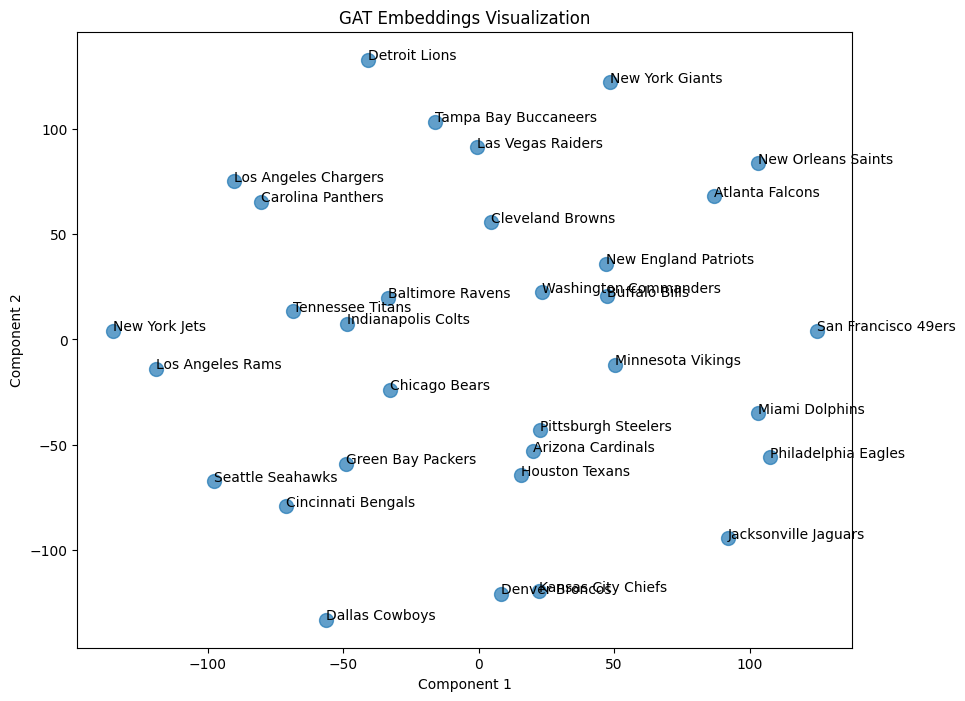

In [41]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming `embeddings` is a tensor of shape [num_nodes, embedding_dim]
embeddings_np = embeddings.cpu().numpy()  # Convert to NumPy for compatibility with sklearn

# Choose either PCA or t-SNE for dimensionality reduction
# Option 1: PCA
# pca = PCA(n_components=2)
# reduced_embeddings = pca.fit_transform(embeddings_np)

# Option 2: t-SNE (for potentially better separation but slower)
tsne = TSNE(n_components=3, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100, alpha=0.7)
plt.title("GAT Embeddings Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Optional: Annotate points with team names or IDs
for i, team in enumerate(teams):
    plt.annotate(team, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()


In [24]:
print(len(teams))

32


In [25]:
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling, train_test_split_edges

##DO NOT DELETE THE CELL BELOW, IT IS ONE GOOD RUN

In [42]:
# Initialize the model
in_channels = node_features.size(1)  # Assuming you use random features as before
hidden_channels = 32
out_channels = 16
model = GATModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# Temporarily remove edge attributes to allow edge splitting
data.edge_attr = None  # Remove edge_attr to use train_test_split_edges

# Perform train/test split on edges
data = train_test_split_edges(data)

# You can still access `edge_attr` separately if needed
edge_attr = data.edge_attr  # Store edge_attr separately if you need it later


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 2. Encode nodes using GAT layers
    z = model.encode(node_features, data.train_pos_edge_index)
    
    # 3. Positive and negative samples for training
    pos_edge_index = data.train_pos_edge_index  # Positive edges from training set
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=pos_edge_index.size(1)
    )  # Random negative samples
    
    # 4. Decode edges
    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)
    
    # 5. Create labels for positive and negative samples
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # 6. Compute loss (binary cross-entropy)
    loss = F.binary_cross_entropy_with_logits(torch.cat([pos_pred, neg_pred]), torch.cat([pos_label, neg_label]))
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation (link prediction on the test set)
model.eval()
with torch.no_grad():
    z = model.encode(node_features, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index)
    neg_pred = model.decode(z, data.test_neg_edge_index)
    
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Concatenate predictions and labels for evaluation
    pred = torch.cat([pos_pred, neg_pred])
    label = torch.cat([pos_label, neg_label])
    
    # Use a threshold (e.g., 0.5) on the sigmoid output to classify edges
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    accuracy = (pred_class == label).sum().item() / label.size(0)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 1/10000, Loss: 0.6885479688644409
Epoch 2/10000, Loss: 2.403796672821045
Epoch 3/10000, Loss: 0.6637434363365173
Epoch 4/10000, Loss: 0.7621362805366516
Epoch 5/10000, Loss: 0.6856999397277832
Epoch 6/10000, Loss: 0.6098058223724365
Epoch 7/10000, Loss: 0.6022646427154541
Epoch 8/10000, Loss: 0.5920215845108032
Epoch 9/10000, Loss: 0.584235429763794
Epoch 10/10000, Loss: 0.5793975591659546
Epoch 11/10000, Loss: 0.565794050693512
Epoch 12/10000, Loss: 0.5260637402534485
Epoch 13/10000, Loss: 0.5388728380203247
Epoch 14/10000, Loss: 0.5007607340812683
Epoch 15/10000, Loss: 0.5377888679504395
Epoch 16/10000, Loss: 0.5165873765945435
Epoch 17/10000, Loss: 0.498009592294693
Epoch 18/10000, Loss: 0.49376147985458374
Epoch 19/10000, Loss: 0.4707419276237488
Epoch 20/10000, Loss: 0.45146119594573975
Epoch 21/10000, Loss: 0.44517481327056885
Epoch 22/10000, Loss: 0.4371582567691803
Epoch 23/10000, Loss: 0.4379545748233795
Epoch 24/10000, Loss: 0.42366689443588257
Epoch 25/10000, Loss: 0.4

In [34]:
# Initialize the model
in_channels = node_features.size(1)  # Assuming you use random features as before
hidden_channels = 128
out_channels = 16
model = GATModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# Temporarily remove edge attributes to allow edge splitting
# data.edge_attr = None  # Remove edge_attr to use train_test_split_edges

# Perform train/test split on edges
# data = train_test_split_edges(data)

# You can still access `edge_attr` separately if needed
edge_attr = data.edge_attr  # Store edge_attr separately if you need it later


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 2. Encode nodes using GAT layers
    z = model.encode(node_features, data.train_pos_edge_index)
    
    # 3. Positive and negative samples for training
    pos_edge_index = data.train_pos_edge_index  # Positive edges from training set
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=pos_edge_index.size(1)
    )  # Random negative samples
    
    # 4. Decode edges
    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)
    
    # 5. Create labels for positive and negative samples
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # 6. Compute loss (binary cross-entropy)
    loss = F.binary_cross_entropy_with_logits(torch.cat([pos_pred, neg_pred]), torch.cat([pos_label, neg_label]))
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation (link prediction on the test set)
model.eval()
with torch.no_grad():
    z = model.encode(node_features, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index)
    neg_pred = model.decode(z, data.test_neg_edge_index)
    
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Concatenate predictions and labels for evaluation
    pred = torch.cat([pos_pred, neg_pred])
    label = torch.cat([pos_label, neg_label])
    
    # Use a threshold (e.g., 0.5) on the sigmoid output to classify edges
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    accuracy = (pred_class == label).sum().item() / label.size(0)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10000, Loss: 0.6932013034820557
Epoch 2/10000, Loss: 2.553091526031494
Epoch 3/10000, Loss: 0.7046388983726501
Epoch 4/10000, Loss: 0.7390088438987732
Epoch 5/10000, Loss: 0.7330771088600159
Epoch 6/10000, Loss: 0.7031505703926086
Epoch 7/10000, Loss: 0.9047444462776184
Epoch 8/10000, Loss: 0.7099764347076416
Epoch 9/10000, Loss: 0.6932325959205627
Epoch 10/10000, Loss: 0.7306996583938599
Epoch 11/10000, Loss: 0.7847978472709656
Epoch 12/10000, Loss: 0.7021337747573853
Epoch 13/10000, Loss: 0.6945863366127014
Epoch 14/10000, Loss: 0.7245451211929321
Epoch 15/10000, Loss: 0.7293493747711182
Epoch 16/10000, Loss: 0.7043507695198059
Epoch 17/10000, Loss: 0.7143705487251282
Epoch 18/10000, Loss: 0.718330979347229
Epoch 19/10000, Loss: 0.6965886950492859
Epoch 20/10000, Loss: 0.692768931388855
Epoch 21/10000, Loss: 0.6967678666114807
Epoch 22/10000, Loss: 0.7137774229049683
Epoch 23/10000, Loss: 0.7090567946434021
Epoch 24/10000, Loss: 0.6949489116668701
Epoch 25/10000, Loss: 0.6926

GCNEmbeddings (Alternative to GAT)

In [35]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEmbeddingModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # The output of this layer will be the node embeddings
        return x

Node Embeddings:
tensor([[ 0.1233, -0.0907, -0.1511, -0.1340, -0.0716,  0.1802,  0.1816, -0.0503,
          0.1508, -0.1225, -0.0660,  0.0696, -0.3402, -0.1862,  0.1848, -0.0147],
        [ 0.1297, -0.1042, -0.1828, -0.1674, -0.0687,  0.2109,  0.2165, -0.0581,
          0.1795, -0.1538, -0.0843,  0.0686, -0.3934, -0.2243,  0.2296, -0.0142],
        [ 0.0757, -0.0900, -0.1582, -0.1325, -0.0396,  0.1664,  0.1755, -0.0465,
          0.1404, -0.1266, -0.0337,  0.0524, -0.3585, -0.1753,  0.1976, -0.0089],
        [ 0.0999, -0.0881, -0.1678, -0.1380, -0.0494,  0.1748,  0.1897, -0.0453,
          0.1454, -0.1430, -0.0823,  0.0568, -0.3380, -0.1801,  0.1962,  0.0028],
        [ 0.1387, -0.0901, -0.1362, -0.1288, -0.0820,  0.1758,  0.1691, -0.0503,
          0.1545, -0.1074, -0.0634,  0.0738, -0.3226, -0.1899,  0.1727, -0.0269],
        [ 0.0859, -0.0851, -0.1584, -0.1219, -0.0419,  0.1603,  0.1718, -0.0418,
          0.1314, -0.1321, -0.0552,  0.0599, -0.3327, -0.1625,  0.1850,  0.0048],
     

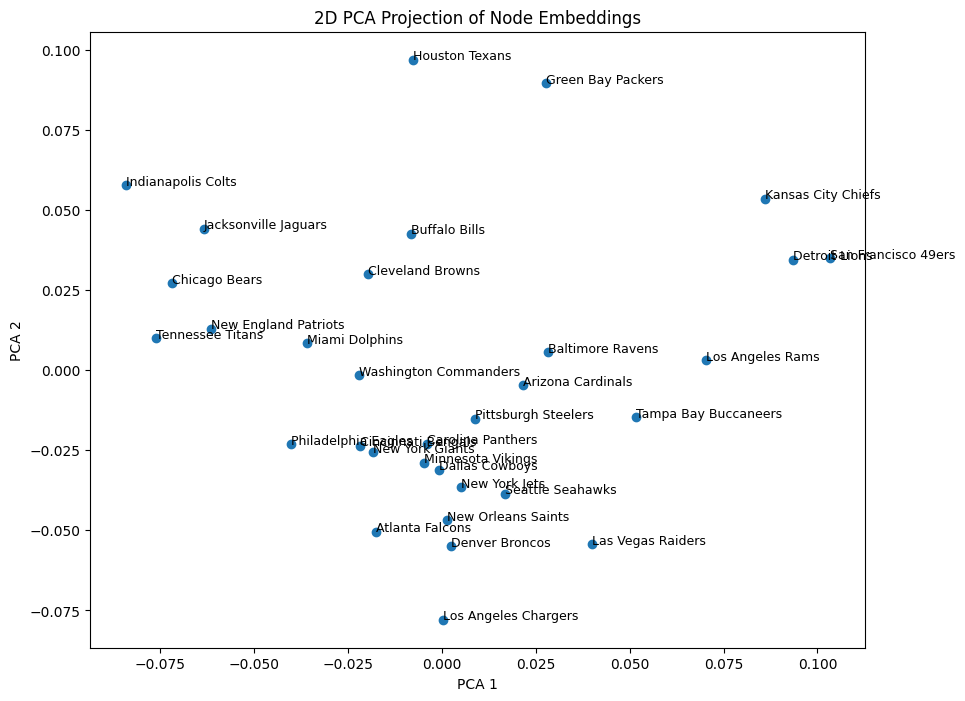

In [36]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the GCN model with embeddings
class GCNEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEmbeddingModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # The output of this layer will be the node embeddings
        return x

# Load data
game_info = pd.read_csv("nfl-game-info.csv")
team_info = pd.read_csv("team_stats_2003_2023.csv")

# Filter games for 2024
game_info_2024 = game_info[game_info['Date'].str.contains("2024")]

# Process teams and create index mapping
teams = pd.concat([game_info_2024['Home Team'], game_info_2024['Away Team']]).unique()
team_to_idx = {team: i for i, team in enumerate(teams)}

# Prepare edge indices and attributes
edge_index = []
edge_attr = []

for _, row in game_info_2024.iterrows():
    team1_idx = team_to_idx[row['Home Team']]
    team2_idx = team_to_idx[row['Away Team']]
    # Add undirected edge with scores as attributes
    edge_index.append([team1_idx, team2_idx])
    edge_index.append([team2_idx, team1_idx])
    edge_attr.append([row["Home Score"], row["Away Score"]])
    edge_attr.append([row["Away Score"], row["Home Score"]])

# Convert to torch tensors and create Data object
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# Prepare node features
# Placeholder: Each team will have a random feature vector (could be enhanced with real stats)
node_features = torch.rand(len(teams), 4)  # Example: 4 features per node (teams)

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))

# Generate labels for each team (for example, 0 for loss, 1 for win, based on 2024 games)
labels = np.zeros(len(teams))  # Initialize all labels as 0 (loss)
for _, row in game_info_2024.iterrows():
    home_team_idx = team_to_idx[row['Home Team']]
    away_team_idx = team_to_idx[row['Away Team']]
    
    if row["Home Score"] > row["Away Score"]:
        labels[home_team_idx] = 1  # Home team wins
    elif row["Away Score"] > row["Home Score"]:
        labels[away_team_idx] = 1  # Away team wins

# Save the labels to a .npy file
np.save('labels.npy', labels)

# Initialize GCN model
input_dim = node_features.size(1)  # Number of features per node
hidden_dim = 16  # Number of hidden units in GCN layer
embedding_dim = 16  # Dimension of output embeddings

model = GCNEmbeddingModel(input_dim=input_dim, hidden_dim=hidden_dim, embedding_dim=embedding_dim)

# Forward pass to generate node embeddings
node_embeddings = model(data)

# Print out the generated embeddings
print("Node Embeddings:")
print(node_embeddings)

# Example: Visualize embeddings (2D projection using PCA or t-SNE)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings.detach().numpy())

# Plotting the 2D PCA projection of the node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])

# Annotating each point with the team names
print(node_embeddings.shape)
for i, team in enumerate(teams):
    plt.text(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1], team, fontsize=9)

plt.title("2D PCA Projection of Node Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [29]:
# Ensure the tensor is on CPU and convert to NumPy array
embeddings_np = node_embeddings.cpu().detach().numpy()

# Save embeddings as a numpy file
import numpy as np
np.save("team_embeddings.npy", embeddings_np)

In [37]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data

# Manually split edges into training and test sets
def train_test_split_edges_manually(edge_index, test_ratio=0.2):
    num_edges = edge_index.size(1)
    test_size = int(num_edges * test_ratio)
    
    # Shuffle edges
    perm = torch.randperm(num_edges)
    test_edges = edge_index[:, perm[:test_size]]
    train_edges = edge_index[:, perm[test_size:]]
    
    return train_edges, test_edges

# Define the GCN model with embeddings and output layer for link prediction
class GCNEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEmbeddingModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)
        self.fc = torch.nn.Linear(embedding_dim * 2, 1)  # Output for binary classification

    def forward(self, x, edge_index):
        # Node encoding through GCN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # Embedding for nodes
        
        # Get the node embeddings for the source and target nodes of each edge
        src, dst = edge_index
        src_embeddings = x[src]
        dst_embeddings = x[dst]
        
        # Concatenate the embeddings of the source and destination nodes
        edge_embeddings = torch.cat([src_embeddings, dst_embeddings], dim=-1)
        
        # Pass the concatenated embeddings through the fully connected layer to get edge scores
        edge_scores = self.fc(edge_embeddings)
        return edge_scores

# Example usage:
train_edges, test_edges = train_test_split_edges_manually(data.edge_index, test_ratio=0.2)
data.train_pos_edge_index = train_edges
data.test_pos_edge_index = test_edges

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = data.x.size(1)
hidden_channels = 32
embedding_dim = 16
model = GCNEmbeddingModel(input_dim=in_channels, hidden_dim=hidden_channels, embedding_dim=embedding_dim).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Encode nodes using GCN layers
    z = model(data.x.to(device), data.train_pos_edge_index.to(device))
    
    # Generate negative samples for the training set
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index, 
        num_nodes=z.size(0),  
        num_neg_samples=pos_edge_index.size(1) 
    )

    # Ensure that no indices are out of bounds
    assert neg_edge_index.max() < z.size(0), "Negative edge index out of bounds"

    # Predictions for positive and negative edges
    pos_pred = model(data.x.to(device), data.train_pos_edge_index.to(device))
    neg_pred = model(data.x.to(device), neg_edge_index.to(device))

    # Labels for positive and negative edges
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Compute loss (binary cross-entropy)
    loss = F.binary_cross_entropy_with_logits(torch.cat([pos_pred, neg_pred]), torch.cat([pos_label, neg_label]))
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation (link prediction on the test set)
model.eval()
with torch.no_grad():
    # Generate negative samples for the test set
    neg_edge_index_test = negative_sampling(
        edge_index=data.test_pos_edge_index,  
        num_nodes=z.size(0),  
        num_neg_samples=data.test_pos_edge_index.size(1)
    )

    # Predictions for the test set
    pos_pred = model(data.x.to(device), data.test_pos_edge_index.to(device))
    neg_pred = model(data.x.to(device), neg_edge_index_test.to(device))
    
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Concatenate predictions and labels for evaluation
    pred = torch.cat([pos_pred, neg_pred])
    label = torch.cat([pos_label, neg_label])
    
    # Apply sigmoid and classification threshold
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    
    # Compute accuracy
    accuracy = (pred_class == label).sum().item() / label.size(0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


RuntimeError: index 237 is out of bounds for dimension 0 with size 32